In [1]:
using Pkg
using DataFrames
using CSV
using Printf
using Plots
using StatsPlots
using Statistics

In [2]:
function parseGCT(fileName, offset = 0)

    rowCount = 0
    version = ""
    rows = 0
    cols = 0
    rowMetadata = 0
    labels = Array{String}[]
    values = Array{}[]
    for row in eachline(fileName)
        if rowCount == 0
            version = row
        elseif rowCount == 1
            # Parse sizes
            splitRow = split(row, "\t")
            row = map(x -> parse(Int, x), splitRow)
            rows = row[1]
            cols = row[2]
            rowMetadata = row[3]
        elseif rowCount == 2
            # Parse Labels
            labels = split(row, "\t")
        elseif rowCount == 3 + offset
            # Parse Values
            values = split(row, "\t")
        end
        rowCount += 1
    end
    parsedData = collect(zip(labels, values))
    metaData = parsedData[1:3]
    overlapPercents = parsedData[4:53]
    overlapSignatures = parsedData[54:103]
    pValues = parsedData[105:154]
    fdrPValues = parsedData[155:204]
    scores = parsedData[205:254]
    annotationsFrame = CSV.read("../data/Annotation_col.csv", DataFrame)
    df = DataFrame(
        annotations = annotationsFrame[!, :Annotation],
        samples = labels[205:254], 
        scores = map(x -> parse(Float64, x), values[205:254]),
        pValues = map(x -> parse(Float64, x), values[105:154]),
        fdrPValues = map(x -> parse(Float64, x), values[155:204])
    )
    return df
end

parseGCT (generic function with 2 methods)

In [3]:
classical = parseGCT("../data/combined/countMatrix_ssGSEA-combined.gct", 0)
mesenchymal = parseGCT("../data/combined/countMatrix_ssGSEA-combined.gct", 1)
neural = parseGCT("../data/combined/countMatrix_ssGSEA-combined.gct", 2)
proneural = parseGCT("../data/combined/countMatrix_ssGSEA-combined.gct", 3)

,annotations,samples,scores,pValues,fdrPValues
,String,SubStri…,Float64,Float64,Float64
1,Core,Sample_27_1,12.469,0.001,0.001
2,Rim,Sample_27_2,12.4474,0.001,0.001
3,Inv,Sample_27_5,11.2262,0.001,0.00133333
4,Neg,Sample_27_neg,12.0779,0.001,0.001
5,Pos,Sample_27_pos,1.2832,0.311765,0.311765
6,Core,Sample_28_1,10.3637,0.001,0.001
7,Rim,Sample_28_2,10.5953,0.001,0.001
8,Inv,Sample_28_5,9.1387,0.001,0.001
9,Neg,Sample_28_neg,6.9967,0.001,0.001


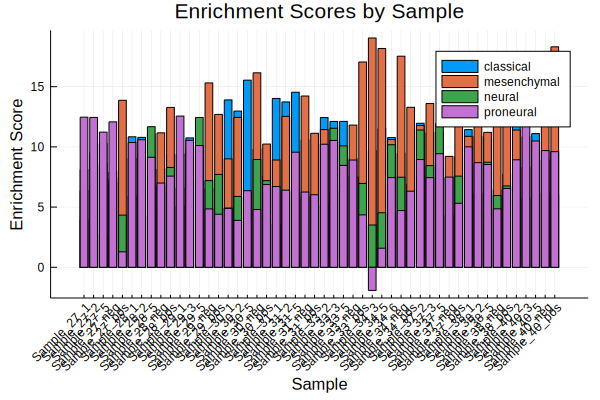

In [17]:
bar(classical.scores, 
    label = "classical", 
    xticks = (1:50, classical.samples), 
    xrotation=45,
    title = "Enrichment Scores by Sample")
xlabel!("Sample")
ylabel!("Enrichment Score")
bar!(mesenchymal.scores, label = "mesenchymal")
bar!(neural.scores, label = "neural")
bar!(proneural.scores, label = "proneural")

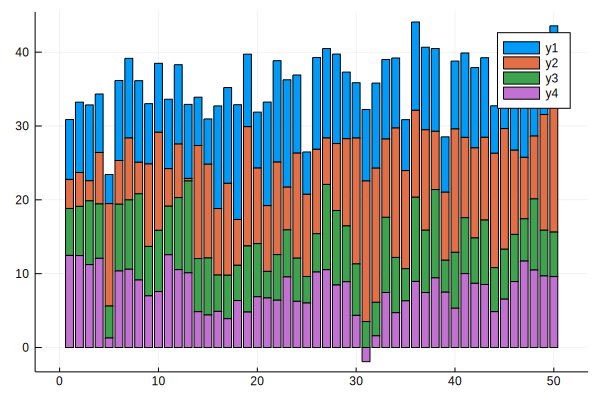

In [18]:
matrixData = [classical.scores mesenchymal.scores neural.scores proneural.scores]
groupedbar(matrixData, bar_position = :stack)

In [19]:
function groupByAnnotation(dataFrame)
    groupedClassical = groupby(dataFrame, :annotations)
    combined = combine(groupedClassical, :scores => mean)
    return combined
end

groupByAnnotation (generic function with 1 method)

In [20]:
# groupByAnnotation(classical)
groupedClassical = groupby(classical, :annotations)

,annotations,samples,scores,pValues,fdrPValues
,String,SubStri…,Float64,Float64,Float64
1,Core,Sample_27_1,8.1146,0.001,0.001
2,Core,Sample_28_1,10.8379,0.001,0.001
3,Core,Sample_29_1,9.4054,0.001,0.001
4,Core,Sample_30_1,13.9015,0.001,0.001
5,Core,Sample_31_1,14.0225,0.001,0.00133333
6,Core,Sample_33_2,12.4356,0.001,0.001
7,Core,Sample_34_3,9.6868,0.001,0.002
8,Core,Sample_37_2,11.9607,0.001,0.001
9,Core,Sample_38_1,11.4344,0.001,0.001


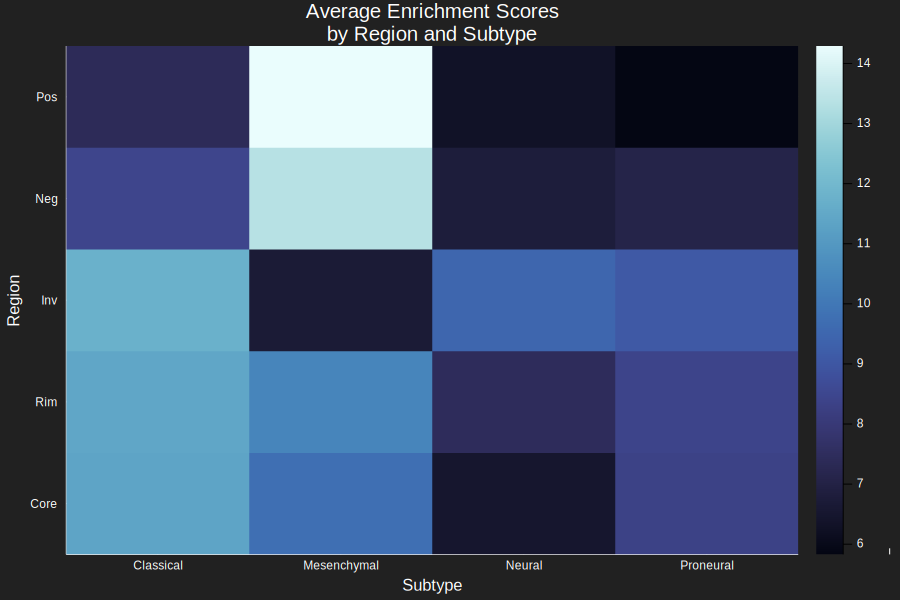

In [140]:
xlabel = ["Classical", "Mesenchymal", "Neural", "Proneural"]
classicalGrouped = groupByAnnotation(classical)
mesenchymalGrouped = groupByAnnotation(mesenchymal)
neuralGrouped = groupByAnnotation(neural)
proneuralGrouped = groupByAnnotation(proneural)
heatmapData = [classicalGrouped.scores_mean (
            mesenchymalGrouped.scores_mean) (
            neuralGrouped.scores_mean) (
            proneuralGrouped.scores_mean)]
heatmap(heatmapData,
    title = "Average Enrichment Scores \nby Region and Subtype",
    xlabel="Subtype",
    ylabel="Region",
    background_color = colorant"#212121ff",
    c = :ice,
#     dpi = 300,
    size = (900, 600),
    yticks=(1:50, classicalGrouped.annotations),
    xticks=(1:5, xlabel))
# savefig("Average Enrichment Scores by Region and Subtype Heatmap")

# Single Patient Analysis

In [157]:
function generateSinglePatientData(patientNumber)
    patientStart = 5 * patientNumber + 1
    patientEnd = 5 * patientNumber + 5
    classicalPatient = classical[patientStart:patientEnd, :]
    mesenchymalPatient = mesenchymal[patientStart:patientEnd, :]
    neuralPatient = neural[patientStart:patientEnd, :]
    proneuralPatient = proneural[patientStart:patientEnd, :]
    heatmapData = [classicalPatient.scores (
                mesenchymalPatient.scores) (
                neuralPatient.scores) (
                proneuralPatient.scores)]
    heatmap(heatmapData,
        title = "Enrichment Scores \nby Region and Subtype for Patient " * string(patientNumber),
        xlabel="Subtype",
        ylabel="Region",
        background_color = colorant"#212121ff",
        c = :ice,
        yticks=(1:50, classicalGrouped.annotations),
        xticks=(1:5, xlabel))
    
    enrichmentScores = DataFrame(
        annotations = classicalPatient.annotations,
        classical = classicalPatient.scores,
        mesenchymal = mesenchymalPatient.scores,
        neural = neuralPatient.scores,
        proneural = proneuralPatient.scores
    )
    
#     CSV.write("results/Single Patient Analysis Results/Enrichment Scores for Patient " * string(classicalPatient.samples[1]) * ".csv", enrichmentScores)
#     savefig("results/Single Patient Analysis Results/Enrichment Scores \n by Region and Subtype for Patient " * string(classicalPatient.samples[1]))
end

generateSinglePatientData (generic function with 1 method)

In [158]:
for i in range(0, stop=9)
    generateSinglePatientData(i)
end

## Group Charts

In [159]:
classicalFiltered = filter(row -> row.fdrPValues < 0.05, classical)
mesenchymalFiltered = filter(row -> row.fdrPValues < 0.05, mesenchymal)
proneuralFiltered = filter(row -> row.fdrPValues < 0.05, proneural)
neuralFiltered = filter(row -> row.fdrPValues < 0.05, neural);

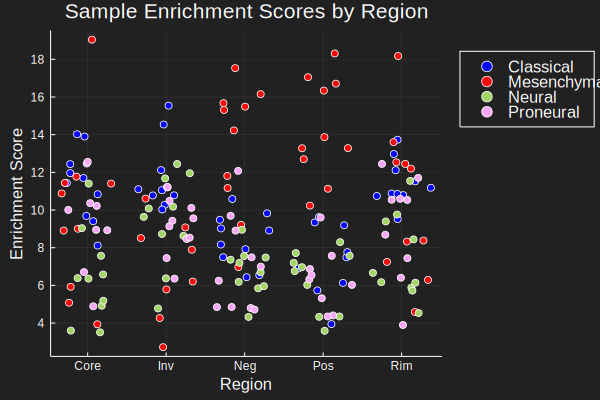

In [180]:
dotplot(classicalFiltered.annotations, classicalFiltered.scores, 
    label="Classical", 
    title="Sample Enrichment Scores by Region",
    xlabel="Region",
    ylabel="Enrichment Score", 
    background_color = colorant"#212121ff",
    marker = (:blue),
#     size=(900, 600),
#     dpi = 300,
    legend = :outertopright)
dotplot!(mesenchymalFiltered.annotations, mesenchymalFiltered.scores, label="Mesenchymal", marker=(:red))
dotplot!(neuralFiltered.annotations, neuralFiltered.scores, label="Neural")
dotplot!(proneuralFiltered.annotations, proneuralFiltered.scores, label="Proneural")
# savefig("results/Single Patient Analysis Results/Enrichment Scores by Region Scatter")

### Filter for Highest Values

In [297]:
topScoresByRegion = DataFrame(score = Any[],
    subtype = String[],
    region = String[],
    sample = String[])
for row in eachrow(classicalFiltered)
    mesenchymalRow = mesenchymalFiltered[mesenchymalFiltered.samples .== row.samples, :]
    neuralRow = neuralFiltered[neuralFiltered.samples .== row.samples, :]
    proneuralRow = proneuralFiltered[proneuralFiltered.samples .== row.samples, :]
    scoresToCompare = []
    push!(scoresToCompare, row.scores)

    if (size(mesenchymalRow.scores)[1] > 0)
        push!(scoresToCompare, mesenchymalRow.scores[1])
    end
    if (size(neuralRow.scores)[1] > 0)
        push!(scoresToCompare, neuralRow.scores[1])
    end
    if (size(proneuralRow.scores)[1] > 0)
        push!(scoresToCompare, proneuralRow.scores[1])
    end
    
    maxIndex = findmax(scoresToCompare)
    maxSubtype = "Classical"
    if (maxIndex[2] == 2)
        maxSubtype = "Mesenchymal"
    end
    if (maxIndex[2] == 3)
        maxSubtype = "Neural"
    end
    if (maxIndex[2] == 4)
        maxSubtype = "Proneural"
    end
    
    push!(topScoresByRegion, [maxIndex[1] maxSubtype row.annotations row.samples])
end

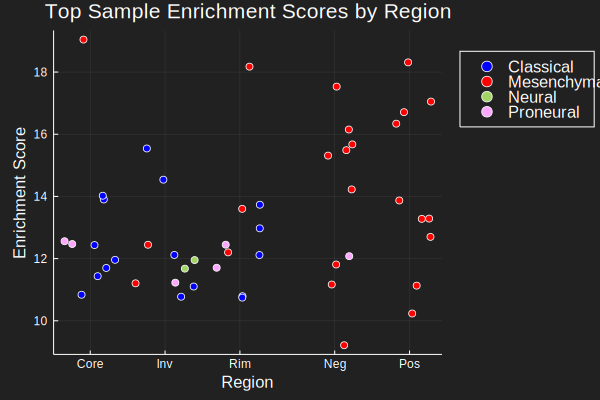

In [321]:
classicalTopScores = topScoresByRegion[topScoresByRegion.subtype .== "Classical", :]
mesenchymalTopScores = topScoresByRegion[topScoresByRegion.subtype .== "Mesenchymal", :]
neuralTopScores = topScoresByRegion[topScoresByRegion.subtype .== "Neural", :]
proneuralTopScores = topScoresByRegion[topScoresByRegion.subtype .== "Proneural", :]
dotplot(
    classicalTopScores.region, 
    classicalTopScores.score,
    label = "Classical",
    title="Top Sample Enrichment Scores by Region",
    xlabel="Region",
    ylabel="Enrichment Score", 
    background_color = colorant"#212121ff",
    marker = (:blue),
#     size=(900, 600),
#     dpi = 300,
    legend = :outertopright
)
dotplot!(
    mesenchymalTopScores.region, 
    mesenchymalTopScores.score,
    label = "Mesenchymal",
    marker=(:red))
dotplot!(
    neuralTopScores.region, 
    neuralTopScores.score,
    label = "Neural")
dotplot!(
    proneuralTopScores.region, 
    proneuralTopScores.score,
    label = "Proneural")
# savefig("results/Single Patient Analysis Results/Top Enrichment Scores by Region Scatter")